In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [24]:
df = pd.read_csv('data.csv')
df.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,1045,1.759105,1.424226,2.213346,2.786321
1,1,450,1532,1.735650,1.372342,2.162660,2.693265
2,2,450,1567,1.737972,1.364822,2.150216,2.660373
3,3,450,1527,1.710710,1.380921,2.096891,2.534916
4,4,450,1532,1.733850,1.385576,2.138852,2.635823


In [25]:
# for testing of data before the accident 
traindf_before =  df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead']].copy()
traindf_before =  traindf_before.iloc[:144, :]
traindf_before =  traindf_before.to_numpy()
traindf_before_list = np.split(traindf_before, 18)

data_to_plot_before = df.iloc[:144, :]
data_to_plot_before = data_to_plot_before.to_numpy()
data_to_plot_before_list = np.split(data_to_plot_before, 18)

# for plotting of data with accident (there is too many points for visible results otherwise)
data_to_plot = df.iloc[::6, :]
data_to_plot = data_to_plot.to_numpy()

In [27]:
import copy


In [28]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) > 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:])
#         plt.xlabel('Number Of Clusers')
#         plt.ylabel('Silhouette Score')
# #         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
        
        print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
                print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
                return int(i[0])
    else:
        print('couldnt get the scores, plz help')
        print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=1)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(s)
#         print('\n')
        return n_clusters_min

In [29]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 12)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [31]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 3)

In [32]:
model_02 = Birch(n_clusters=None, threshold=0.2)

for i in data_split_modified_z_12_list:
    model_02.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_02, data_split_modified_z_12[:, :-2], 2, 6)

model_02.set_params(n_clusters = n)
model_02.partial_fit()
    
labels_02 = model_02.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_01= Birch(n_clusters=None, threshold=0.1)

for i in data_split_modified_z_12_list:
    model_01.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_01, data_split_modified_z_12[:, :-2], 2, 6)

model_01.set_params(n_clusters = n)
model_01.partial_fit()
    
labels_01 = model_01.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_03 = Birch(n_clusters=None, threshold=0.3)

for i in data_split_modified_z_12_list:
    model_03.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_03, data_split_modified_z_12[:, :-2], 2, 6)

model_03.set_params(n_clusters = n)
model_03.partial_fit()
    
labels_03 = model_03.predict(data_split_modified_z_12[:, :-2])

##########################################################
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :-2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :-2])

##############################################################
model_001 = Birch(n_clusters=None, threshold=0.01)

for i in data_split_modified_z_12_list:
    model_001.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_001, data_split_modified_z_12[:, :-2], 2, 6)

model_001.set_params(n_clusters = n)
model_001.partial_fit()
    
labels_001 = model_001.predict(data_split_modified_z_12[:, :-2])

##############################################################
model = Birch(n_clusters=None, threshold=0.5)

for i in data_split_modified_z_12_list:
    model.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model, data_split_modified_z_12[:, :-2], 2, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels = model.predict(data_split_modified_z_12[:, :-2])

[(2, 0.6935996062142026), (3, 0.6438424446317251), (4, 0.6438424446317251), (5, 0.6438424446317251), (6, 0.6438424446317251)]
The highest silhouette scores(0.6935996062142026) is for 2 clusers
[(2, 0.6954461366637911), (3, 0.6409466051415363), (4, 0.6255097292699585), (5, 0.5315190551245617), (6, 0.4958597671928517)]
The highest silhouette scores(0.6954461366637911) is for 2 clusers
[(2, 0.6935996062142026), (3, 0.6316297171544302), (4, 0.6316297171544302), (5, 0.6316297171544302), (6, 0.6316297171544302)]
The highest silhouette scores(0.6935996062142026) is for 2 clusers
[(2, 0.6954461366637911), (3, 0.636089553115487), (4, 0.5197028573205377), (5, 0.4575348502741125), (6, 0.45014970142625826)]
The highest silhouette scores(0.6954461366637911) is for 2 clusers
[(2, 0.6954461366637911), (3, 0.6370076354329345), (4, 0.5432304616512613), (5, 0.48957210500802967), (6, 0.44491699209557084)]
The highest silhouette scores(0.6954461366637911) is for 2 clusers
couldnt get the scores, plz help


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (5). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

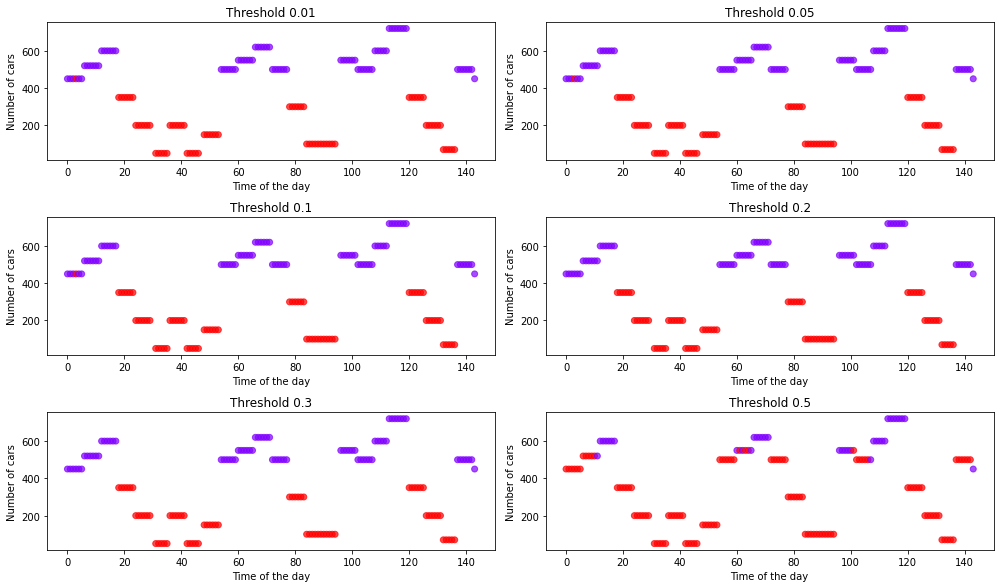

In [33]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_001, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='r')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time of the day')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_005, cmap='rainbow', alpha=0.7)
# axs[0,0].axvline(x=143, color='r')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time of the day')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_01, cmap='rainbow', alpha=0.7)    
# axs[0,1].axvline(x=143, color='r')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time of the day')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_02, cmap='rainbow', alpha=0.7)   
# axs[1,0].axvline(x=143, color='r')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time of the day')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_03, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time of the day')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels, cmap='rainbow', alpha=0.7)
# axs[1,1].axvline(x=143, color='r')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time of the day')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
# figure.suptitle('Test of different Thresholds for BIRCH model', fontsize=20)

In [34]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
# data_split_modified_z = data_split_modified_z.iloc[:144, :]
data_split_modified_z = data_split_modified_z.to_numpy()

""" SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 3)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
#         print(median_absolute_deviation_y)
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
#             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#     print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [36]:
data_split_modified_z_12_list = np.split(data_split_modified_z_12, 1)

In [37]:
model_02 = Birch(n_clusters=None, threshold=0.2)

for i in data_split_modified_z_12_list:
    model_02.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_02, data_split_modified_z_12[:, :-2], 2, 6)

model_02.set_params(n_clusters = n)
model_02.partial_fit()
    
labels_02 = model_02.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_01= Birch(n_clusters=None, threshold=0.1)

for i in data_split_modified_z_12_list:
    model_01.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_01, data_split_modified_z_12[:, :-2], 2, 6)

model_01.set_params(n_clusters = n)
model_01.partial_fit()
    
labels_01 = model_01.predict(data_split_modified_z_12[:, :-2])
##########################################################
model_03 = Birch(n_clusters=None, threshold=0.3)

for i in data_split_modified_z_12_list:
    model_03.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_03, data_split_modified_z_12[:, :-2], 2, 6)

model_03.set_params(n_clusters = n)
model_03.partial_fit()
    
labels_03 = model_03.predict(data_split_modified_z_12[:, :-2])

##########################################################
model_005 = Birch(n_clusters=None, threshold=0.05)

for i in data_split_modified_z_12_list:
    model_005.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_005, data_split_modified_z_12[:, :-2], 2, 6)

model_005.set_params(n_clusters = n)
model_005.partial_fit()
    
labels_005 = model_005.predict(data_split_modified_z_12[:, :-2])

##############################################################
model_001 = Birch(n_clusters=None, threshold=0.01)

for i in data_split_modified_z_12_list:
    model_001.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model_001, data_split_modified_z_12[:, :-2], 2, 6)

model_001.set_params(n_clusters = n)
model_001.partial_fit()
    
labels_001 = model_001.predict(data_split_modified_z_12[:, :-2])

##############################################################
model = Birch(n_clusters=None, threshold=0.5)

for i in data_split_modified_z_12_list:
    model.partial_fit(i[:, :-2])

# model.partial_fit(test_normal)

n = plot_silhouette_scores(model, data_split_modified_z_12[:, :-2], 2, 6)

model.set_params(n_clusters = n)
model.partial_fit()
    
labels = model.predict(data_split_modified_z_12[:, :-2])

[(2, 0.48888373264852525), (3, 0.4691526512729408), (4, 0.45357319504155824), (5, 0.4789486760853696), (6, 0.47401300341590225)]
The highest silhouette scores(0.48888373264852525) is for 2 clusers
[(2, 0.5130790921200367), (3, 0.5077511649963101), (4, 0.48501536394021333), (5, 0.451687068918494), (6, 0.4728465095112274)]
The highest silhouette scores(0.5130790921200367) is for 2 clusers
[(2, 0.5516435008826783), (3, 0.525669204931416), (4, 0.4984117511840187), (5, 0.4931106677837022), (6, 0.4931106677837022)]
The highest silhouette scores(0.5516435008826783) is for 2 clusers
[(2, 0.5502295427309384), (3, 0.44825925057612576), (4, 0.42197679882437), (5, 0.42276521974490266), (6, 0.4141348633773495)]
The highest silhouette scores(0.5502295427309384) is for 2 clusers
[(2, 0.5488503070592577), (3, 0.4199446992144818), (4, 0.4214835139597045), (5, 0.42051485064081473), (6, 0.44422108410426825)]
The highest silhouette scores(0.5488503070592577) is for 2 clusers
couldnt get the scores, plz he

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)


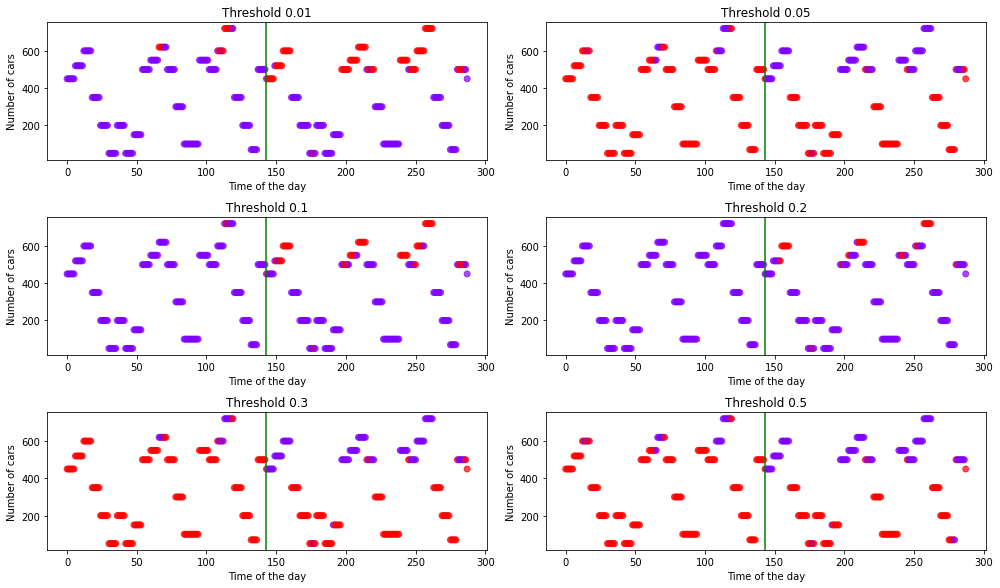

In [38]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_001, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time of the day')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_005, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time of the day')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_01, cmap='rainbow', alpha=0.7)    
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time of the day')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_02, cmap='rainbow', alpha=0.7)   
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time of the day')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels_03, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time of the day')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_split_modified_z_12[:,5], data_split_modified_z_12[:,4], c=labels, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time of the day')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
# figure.suptitle('Test of different Thresholds for BIRCH model', fontsize=20)

In [41]:
traindf = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead']].copy()
traindf = traindf.to_numpy()
traindf_list = np.split(traindf, 18)

In [42]:

model_001_whole  = Birch(n_clusters=None, threshold=0.01)

for i in traindf_list:
    model_001_whole.partial_fit(i
                               )

# model.partial_fit(test_normal)
print('threshold 001')
n = plot_silhouette_scores(model_001_whole, data_to_plot[:, 3:], 2, 10)

model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()
    
labels_001_whole = model_001_whole.predict(data_to_plot[:, 3:])


##########################################################
model_005_whole = Birch(n_clusters=None, threshold=0.05)

for i in traindf_list:
    model_005_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 005')
n = plot_silhouette_scores(model_005_whole, traindf, 2, 10)

model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()
    
labels_005_whole = model_005_whole.predict(data_to_plot[:, 3:])

model_01_whole = Birch(n_clusters=None, threshold=0.1)

for i in traindf_list:
    model_01_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 01')
n = plot_silhouette_scores(model_01_whole, traindf, 2,10)

model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()
    
labels_01_whole = model_01_whole.predict(data_to_plot[:, 3:])


model_02_whole = Birch(n_clusters=None, threshold=0.2)

for i in traindf_list:
    model_02_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 02')
n = plot_silhouette_scores(model_02_whole, traindf, 2,10)

model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()
    
labels_02_whole = model_02_whole.predict(data_to_plot[:, 3:])
##########################################################

##########################################################
model_03_whole = Birch(n_clusters=None, threshold=0.3)

for i in traindf_list:
    model_03_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 03')
n = plot_silhouette_scores(model_03_whole, traindf, 2,10)

model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()
    
labels_03_whole = model_03_whole.predict(data_to_plot[:, 3:])


##############################################################

##############################################################
model_whole = Birch(n_clusters=None, threshold=0.5)

for i in traindf_list:
    model_whole.partial_fit(i)

# model.partial_fit(test_normal)
print('threshold 05')
n = plot_silhouette_scores(model_whole, data_to_plot[:, 3:], 2,10)

model_whole.set_params(n_clusters = n)
model_whole.partial_fit()
    
labels_whole = model_whole.predict(data_to_plot[:, 3:])

threshold 001
[(2, 0.5607126655841885), (3, 0.3220878099602365), (4, 0.37061240209711405), (5, 0.37503480325128963), (6, 0.3710880362156286), (7, 0.34004878436117214), (8, 0.3597543972220798), (9, 0.3706221330368757), (10, 0.3850800201214019)]
The highest silhouette scores(0.5607126655841885) is for 2 clusers
threshold 005
[(2, 0.5502295427309387), (3, 0.44825925057612614), (4, 0.4219767988243712), (5, 0.4227652197449048), (6, 0.4141348633773515), (7, 0.4351121910227473), (8, 0.4056534168502013), (9, 0.4044935581231219), (10, 0.378883510125136)]
The highest silhouette scores(0.5502295427309387) is for 2 clusers
threshold 01
[(2, 0.513079092120037), (3, 0.507751164996311), (4, 0.4850153639402144), (5, 0.4516870689184949), (6, 0.47284650951122953), (7, 0.46715906759518444), (8, 0.4537018457266314), (9, 0.43862455106405995), (10, 0.4280977577102418)]
The highest silhouette scores(0.513079092120037) is for 2 clusers
threshold 02
[(2, 0.48888373264852564), (3, 0.4691526512729415), (4, 0.453

/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (7). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (5) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

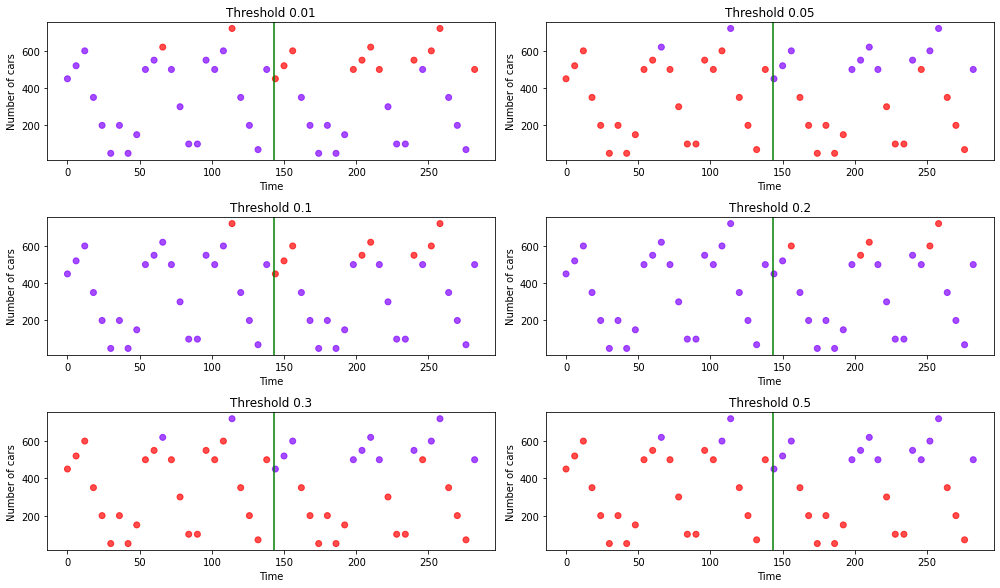

In [43]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(14,9))

axs[0,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_001_whole, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_005_whole, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_01_whole, cmap='rainbow', alpha=0.7)    
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_02_whole, cmap='rainbow', alpha=0.7)   
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_03_whole, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(data_to_plot[:,0], data_to_plot[:,1], c=labels_whole, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])
